# Creating an Agent to play PacMan using a Deep Q Network


In [1]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import flatten, conv2d, fully_connected
from collections import deque, Counter
import random
from datetime import datetime
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

gymlogger.set_level(40) #error only
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
print(tf.__version__)

1.13.2


Lets define a function that:
* trims the image size beforehand 
* converts images into a grayscale 1D tensor 
* impoves the contrast for better visibility 
* normalizes the image from -1 to +1

The function returns an image the shape of which is (88, 80, 1)




In [3]:
color = np.array([210, 164, 74]).mean()

def reformat_image(capture):
    img = capture[1:176:2, ::2]
    img = img.mean(axis=2)
    img[img==color] = 0
    img = (img - 128) / 128 - 1

    return img.reshape(88,80,1)


* The next step is creating the environment and showing examples screen captures from the game.
* We can also see all the available actions and compare the creen capture from the gym env to our reformated image.



9
['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


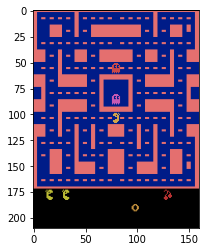

In [4]:
env = gym.make("MsPacman-v0")
actions_count = env.action_space.n
print(actions_count)
print(env.env.get_action_meanings())
screen_capture = env.reset()

plt.imshow(screen_capture)
plt.show()
  

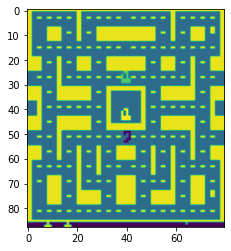

(210, 160, 3)
(88, 80)


In [5]:
image = reformat_image(screen_capture).reshape(88,80)
plt.imshow(image)
plt.show()
print(screen_capture.shape)
print(image.shape)

Lets define a function that builds our deep Q network: 
* initialize three convolutional layers with padding='SAME'
* flatten the output of the last layer
* feed the the flattened output to the fully connected layer
* add final output layer
* the function returns the parameters of the network and the probabilities of taking each action

In [6]:
tf.compat.v1.reset_default_graph()
def dqn(X, name_scope):

    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=2.0)
    with tf.compat.v1.variable_scope(name_scope) as scope: 

        conv_1 = conv2d(X, num_outputs=32, kernel_size=(8,8), stride=4, padding='SAME', weights_initializer=initializer) 
        tf.compat.v1.summary.histogram('conv_layer_1',conv_1)
        
        conv_2 = conv2d(conv_1, num_outputs=64, kernel_size=(4,4), stride=2, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('conv_layer_2',conv_2)
        
        conv_3 = conv2d(conv_2, num_outputs=64, kernel_size=(3,3), stride=1, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('conv_layer_3',conv_3)
        
        flattened = flatten(conv_3)
 
        fc = fully_connected(flattened, num_outputs=128, weights_initializer=initializer)
        tf.compat.v1.summary.histogram('fc',fc)

        output = fully_connected(fc, num_outputs=actions_count, activation_fn=None, weights_initializer=initializer)
        tf.compat.v1.summary.histogram('output',output)
        
        network_parameters = {p.name[len(scope.name):]: p for p in tf.compat.v1.get_collection(key=tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)} 
        return network_parameters, output

In order for the agent to visit every single possible state-action combination, we will get the next action using the epsilon greedy policy. Its idea is that the next action will be random with a probability of [1 - eps] with epsilon decaying over time. 

This means that we will either chose the best action or a random one and the probability of choosing the best action will increase over time.





In [7]:
epsilon = 0.5
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 500000

def greedy_policy(action, step):
    p = np.random.random(1).squeeze() 
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(actions_count)
    else:
        return action

Our gameplay information is built on the SARSA model which stands for:
State-Action-Reward-State-Action and we will be storing this information in a buffer of experiences. </br>

We will use this buffer to generate samples in order to genereate y-values and train the network.



In [8]:
buff_size = 20000
experiences = deque(maxlen=buff_size)

def get_experience_batch(batch_size):
    batch = np.random.permutation(len(experiences))[:batch_size]
    sarsa_batch = np.array(experiences)[batch]

    states = sarsa_batch[:,0]
    actions = sarsa_batch[:,1]
    next_states = sarsa_batch[:,2]
    rewards = sarsa_batch[:,3]
    are_terminated = sarsa_batch[:,4]

    return states, actions, next_states, rewards, are_terminated


**Hyperparameters of the network**

In [9]:
num_episodes = 2000
batch_size = 48
input_shape = (None, 88, 80, 1)
learning_rate = 0.001
X_shape = (None, 88, 80, 1)
discount_factor = 0.97

global_step = 0
copy_steps = 100
steps_train = 4
start_steps = 2000

In [10]:
tf.compat.v1.reset_default_graph()

X = tf.compat.v1.placeholder(tf.float32, shape=X_shape)
in_training_mode = tf.compat.v1.placeholder(tf.bool)

In order to train and generate the data concurently we define two networks using our dqn function. 

The primaryQ updated exactly one state-action value per timestep whereas the targetQ network will be used to compute the loss for every action during training. 

**But why do we need a second network?**

Conceptually it's like saying, "I have an idea of how to play this well, I'm going to try it out for a bit until I find something better" as opposed to saying "I'm going to retrain myself how to play this entire game after every move".

In [11]:
primaryQ, primaryQ_outputs = dqn(X, 'primaryQ')
targetQ, targetQ_outputs = dqn(X, 'targetQ')

X_action = tf.compat.v1.placeholder(tf.int32, shape=(None,))
Q_action = tf.reduce_sum(input_tensor=targetQ_outputs * tf.one_hot(X_action, actions_count), axis=-1, keepdims=True)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.


Copy the primary Q network parameters to the target  Q network

In [12]:
copy_op = [tf.compat.v1.assign(main_name, targetQ[var_name]) for var_name, main_name in primaryQ.items()]
copy_primary_to_target = tf.group(*copy_op)


In [13]:
y = tf.compat.v1.placeholder(tf.float32, shape=(None,1))
loss = tf.reduce_mean(input_tensor=tf.square(y - Q_action))

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.compat.v1.global_variables_initializer()
loss_summary = tf.compat.v1.summary.scalar('LOSS', loss)


Instructions for updating:
Use tf.cast instead.


Lets start the tensoflow session. Every episode consists of the following actions:
* Get the screen capture for the current state 
* Reformat the screen capture
* Get the best action for the state from the primary network
* Generate next action using the greedy policy
* Perform action and get to the next state
* Get the next screen capture
* Receive reward through the gym env step function
* Store this transition in the experiences buffer
* After a set amount of steps we can train our network with a sample experience batch
* Calculate loss
* At a certain point copy the primary network into the target network



In [14]:
with tf.compat.v1.Session() as sess:
    init.run()
    
    all_rewards = []
    for i in range(num_episodes):
        terminated = False
        capture = env.reset()
        epoch = 0
        episodic_reward = 0
        actions_counter = Counter() 
        episodic_loss = []
 
        while not terminated:
            capture = reformat_image(capture)
 
            actions = primaryQ_outputs.eval(feed_dict={X:[capture], in_training_mode:False})
 
            action = np.argmax(actions, axis=-1)
            actions_counter[str(action)] += 1 
 
            action = greedy_policy(action, global_step)
            
            next_capture, reward, terminated, _ = env.step(action)
 
            experiences.append([capture, action, reformat_image(next_capture), reward, terminated])
            
            if global_step % steps_train == 0 and global_step > start_steps:
                states, actions, next_states, rewards, are_terminated = get_experience_batch(batch_size)
                states = list(states)
                next_states = list(next_states)
 
                next_actions = primaryQ_outputs.eval(feed_dict={X:next_states, in_training_mode:False})
 
                y_batch = rewards + discount_factor * np.max(next_actions, axis=-1) * (1-are_terminated) 
 
                train_loss, _ = sess.run([loss, training_op], feed_dict={X:states, y:np.expand_dims(y_batch, axis=-1), X_action:actions, in_training_mode:True})
                episodic_loss.append(train_loss)
            
            if (global_step+1) % copy_steps == 0 and global_step > start_steps:
                copy_primary_to_target.run()
                
            capture = next_capture
            epoch += 1
            global_step += 1
            episodic_reward += reward
        
        all_rewards.append(episodic_reward)
        print('Epochs per episode:', epoch, 'Episode Reward:', episodic_reward,"Episode number:", len(all_rewards))

Epochs per episode: 651 Episode Reward: 170.0 Episode number: 1
Epochs per episode: 691 Episode Reward: 270.0 Episode number: 2
Epochs per episode: 744 Episode Reward: 250.0 Episode number: 3
Epochs per episode: 696 Episode Reward: 150.0 Episode number: 4
Epochs per episode: 504 Episode Reward: 150.0 Episode number: 5
Epochs per episode: 628 Episode Reward: 170.0 Episode number: 6
Epochs per episode: 641 Episode Reward: 270.0 Episode number: 7
Epochs per episode: 720 Episode Reward: 230.0 Episode number: 8
Epochs per episode: 823 Episode Reward: 290.0 Episode number: 9
Epochs per episode: 607 Episode Reward: 170.0 Episode number: 10
Epochs per episode: 669 Episode Reward: 310.0 Episode number: 11
Epochs per episode: 712 Episode Reward: 300.0 Episode number: 12
Epochs per episode: 554 Episode Reward: 160.0 Episode number: 13
Epochs per episode: 680 Episode Reward: 170.0 Episode number: 14
Epochs per episode: 560 Episode Reward: 130.0 Episode number: 15
Epochs per episode: 602 Episode Re

KeyboardInterrupt: ignored

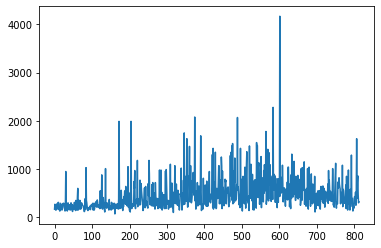

In [16]:
plt.plot(all_rewards)
plt.show()

In [17]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [18]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [19]:
#Evaluate model on openAi GYM
env = wrap_env(gym.make('MsPacman-v0'))
screen_capture = env.reset()
new_screen_capture = screen_capture

prev_input = None
terminated = False

with tf.compat.v1.Session() as sess:
    init.run()
    while True:
      if True: 
        image = reformat_image(screen_capture)
        actions = primaryQ_outputs.eval(feed_dict={X:[image], in_training_mode:False})

        action = np.argmax(actions, axis=-1)
        actions_counter[str(action)] += 1 

        action = greedy_policy(action, global_step)
        env.render()
        screen_capture = new_screen_capture        
        new_screen_capture, reward, terminated, _ = env.step(action)

        if terminated: 
          break
      
    env.close()
    show_video()